Data shape: (2240, 29)
     ID  Year_Birth   Education Marital_Status   Income  Kidhome  Teenhome  \
0  5524        1957  Graduation         Single  58138.0        0         0   
1  2174        1954  Graduation         Single  46344.0        1         1   
2  4141        1965  Graduation       Together  71613.0        0         0   
3  6182        1984  Graduation       Together  26646.0        1         0   
4  5324        1981         PhD        Married  58293.0        1         0   

  Dt_Customer  Recency  MntWines  ...  NumWebVisitsMonth  AcceptedCmp3  \
0  04-09-2012       58       635  ...                  7             0   
1  08-03-2014       38        11  ...                  5             0   
2  21-08-2013       26       426  ...                  4             0   
3  10-02-2014       26        11  ...                  6             0   
4  19-01-2014       94       173  ...                  5             0   

   AcceptedCmp4  AcceptedCmp5  AcceptedCmp1  AcceptedCmp2  Comp

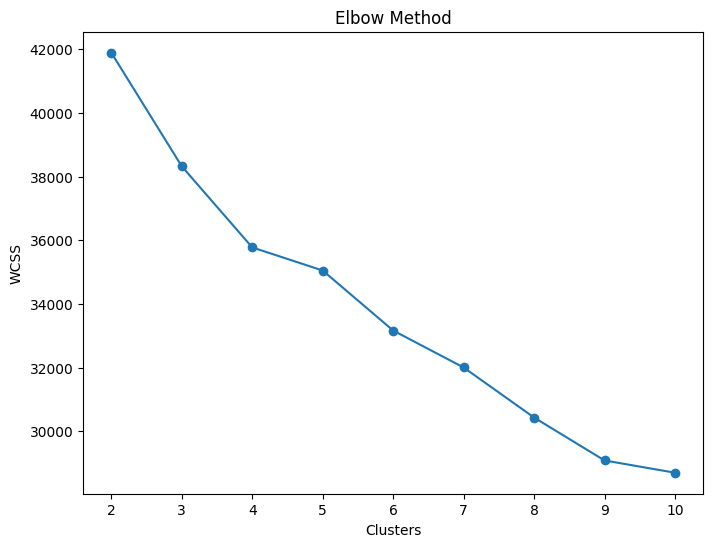


KMeans Metrics:
Silhouette: 0.1811
Calinski-Harabasz: 358.8180
Davies-Bouldin: 2.1205
Dunn Index: 0.0319

DBSCAN Grid Search Results:
    eps  min_samples  n_clusters  silhouette  calinski_harabasz  \
0   0.5            3           1         NaN                NaN   
1   0.5            5           0         NaN                NaN   
2   0.5            7           0         NaN                NaN   
3   1.0            3          31    0.073841          22.474742   
4   1.0            5           9    0.014843          23.211156   
5   1.0            7           5    0.209099          25.759476   
6   1.5            3          28    0.116278          36.785733   
7   1.5            5          11    0.181175          64.439467   
8   1.5            7           9    0.173887          70.515956   
9   2.0            3          27   -0.004707          17.644066   
10  2.0            5          10    0.121940          26.761611   
11  2.0            7           6    0.156085          36.6137

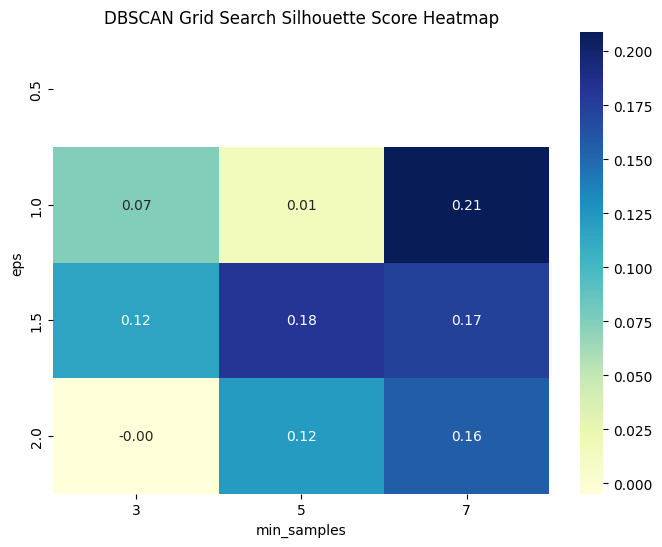


Best DBSCAN Combination:
eps                   1.000000
min_samples           7.000000
n_clusters            5.000000
silhouette            0.209099
calinski_harabasz    25.759476
davies_bouldin        1.085613
dunn_index            0.172915
Name: 5, dtype: float64

DBSCAN Final Metrics:
Silhouette: 0.2091
Calinski-Harabasz: 25.7595
Davies-Bouldin: 1.0856
Dunn Index: 0.1729


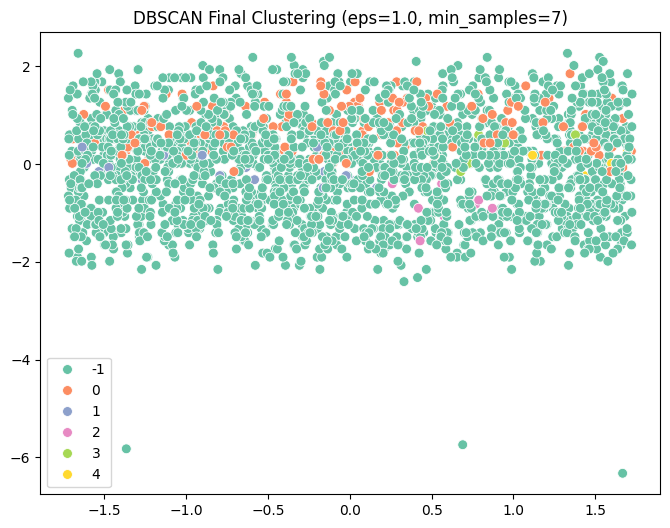

In [ ]:
# ======================
# 📌 IMPORT
# ======================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from scipy.spatial.distance import cdist

# ======================
# 📌 LOAD DATA
# ======================
url = 'https://raw.githubusercontent.com/farrelrassya/teachingMLDL/main/01.%20Machine%20Learning/06.%20Week%206/Datasets/clusteringcampaign.csv'
df = pd.read_csv(url, sep='\t')

print("Data shape:", df.shape)
print(df.head())

# ======================
# 📌 PILIH FITUR NUMERIK + TANGANI NaN
# ======================
X = df.select_dtypes(include=[np.number])
print("\nFitur numerik untuk clustering:")
print(X.columns.tolist())
print("\nJumlah missing per kolom:")
print(X.isnull().sum())

X = X.dropna()

# ======================
# 📌 SCALING
# ======================
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ======================
# 📌 ELBOW KMEANS
# ======================
wcss = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(8,6))
plt.plot(range(2,11), wcss, marker='o')
plt.title('Elbow Method')
plt.xlabel('Clusters')
plt.ylabel('WCSS')
plt.show()

# ======================
# 📌 KMEANS FIT + METRIK
# ======================
best_k = 4
kmeans = KMeans(n_clusters=best_k, random_state=42)
k_labels = kmeans.fit_predict(X_scaled)

print("\nKMeans Metrics:")
print(f"Silhouette: {silhouette_score(X_scaled, k_labels):.4f}")
print(f"Calinski-Harabasz: {calinski_harabasz_score(X_scaled, k_labels):.4f}")
print(f"Davies-Bouldin: {davies_bouldin_score(X_scaled, k_labels):.4f}")

# ======================
# 📌 DUNN INDEX
# ======================
def dunn_index(X, labels):
    clusters = np.unique(labels)
    clusters = clusters[clusters != -1]
    if len(clusters) < 2:
        return None
    min_inter = np.inf
    max_intra = 0
    for i in clusters:
        Xi = X[labels == i]
        for j in clusters:
            if i >= j:
                continue
            Xj = X[labels == j]
            dist = cdist(Xi, Xj)
            min_inter = min(min_inter, np.min(dist))
        intra = cdist(Xi, Xi)
        max_intra = max(max_intra, np.max(intra))
    if max_intra == 0:
        return None
    return min_inter / max_intra

dunn_kmeans = dunn_index(X_scaled, k_labels)
print(f"Dunn Index: {dunn_kmeans:.4f}" if dunn_kmeans else "Dunn Index: Tidak valid")

# ======================
# 📌 DBSCAN GRID SEARCH
# ======================
eps_values = [0.5, 1.0, 1.5, 2.0]
min_samples_values = [3, 5, 7]
results = []

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        db_labels = dbscan.fit_predict(X_scaled)
        mask = db_labels != -1
        unique_clusters = np.unique(db_labels[mask])

        if len(unique_clusters) > 1:
            sil = silhouette_score(X_scaled[mask], db_labels[mask])
            ch = calinski_harabasz_score(X_scaled[mask], db_labels[mask])
            dbi = davies_bouldin_score(X_scaled[mask], db_labels[mask])
            dunn = dunn_index(X_scaled, db_labels)
        else:
            sil = ch = dbi = dunn = None

        results.append({
            'eps': eps,
            'min_samples': min_samples,
            'n_clusters': len(unique_clusters),
            'silhouette': sil,
            'calinski_harabasz': ch,
            'davies_bouldin': dbi,
            'dunn_index': dunn
        })

df_grid = pd.DataFrame(results)
print("\nDBSCAN Grid Search Results:")
print(df_grid)

# ======================
# 📌 HEATMAP SILHOUETTE
# ======================
pivot_sil = df_grid.pivot(index='eps', columns='min_samples', values='silhouette')
plt.figure(figsize=(8,6))
sns.heatmap(pivot_sil, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("DBSCAN Grid Search Silhouette Score Heatmap")
plt.show()

# ======================
# 📌 PILIH DBSCAN TERBAIK + FINAL FIT
# ======================
valid_results = df_grid.dropna(subset=['silhouette'])
if not valid_results.empty:
    best_result = valid_results.sort_values(by='silhouette', ascending=False).iloc[0]
    print("\nBest DBSCAN Combination:")
    print(best_result)

    eps_best = best_result['eps']
    min_samples_best = int(best_result['min_samples'])

    dbscan_final = DBSCAN(eps=eps_best, min_samples=min_samples_best)
    db_labels_final = dbscan_final.fit_predict(X_scaled)

    mask = db_labels_final != -1
    if len(np.unique(db_labels_final[mask])) > 1:
        print("\nDBSCAN Final Metrics:")
        print(f"Silhouette: {silhouette_score(X_scaled[mask], db_labels_final[mask]):.4f}")
        print(f"Calinski-Harabasz: {calinski_harabasz_score(X_scaled[mask], db_labels_final[mask]):.4f}")
        print(f"Davies-Bouldin: {davies_bouldin_score(X_scaled[mask], db_labels_final[mask]):.4f}")
        dunn_final = dunn_index(X_scaled, db_labels_final)
        print(f"Dunn Index: {dunn_final:.4f}" if dunn_final else "Dunn Index: Tidak valid")

        plt.figure(figsize=(8,6))
        sns.scatterplot(x=X_scaled[:,0], y=X_scaled[:,1], hue=db_labels_final, palette='Set2', s=50)
        plt.title(f"DBSCAN Final Clustering (eps={eps_best}, min_samples={min_samples_best})")
        plt.show()
    else:
        print("DBSCAN Final tidak menghasilkan cluster valid (cluster < 2).")
else:
    print("DBSCAN tidak menghasilkan kombinasi valid (cluster < 2).")


📌 KMeans
\
✅ KMeans cenderung menghasilkan:
\
\
Silhouette Score tinggi (biasanya di atas 0.5) jika data memiliki struktur cluster bulat/linier.

Calinski-Harabasz (CH) Index tinggi → menunjukkan cluster compact (rapat) dan terpisah baik.

Davies-Bouldin (DB) Index rendah → cluster compact dan berjauhan satu sama lain.

Dunn Index cukup tinggi → jarak antar cluster relatif besar dibanding diameter cluster.
\
\
👉 Kapan KMeans ideal?

Saat data terdistribusi dalam cluster yang bulat, linier, dan ukuran cluster seragam.
\
\
📌 DBSCAN
✅ DBSCAN efektif pada:

Data dengan bentuk cluster bebas (non-linier, tidak harus bulat).

Bisa mendeteksi outlier/noise (label -1).

Silhouette Score bisa tinggi jika DBSCAN menemukan struktur alami cluster.

CH Index dan DB Index bisa turun jika banyak noise / cluster kecil.

Dunn Index sering lebih tinggi jika DBSCAN sukses memisahkan cluster bentuk bebas.
\
\
👉 Kapan DBSCAN ideal?

Data dengan cluster bentuk tak teratur.

Ada outlier yang ingin diidentifikasi.
\
\
📌 Rekomendasi Matriks Terbaik
\
💡 Silhouette Score → matrik utama: semakin tinggi semakin baik, intuitif untuk semua model.
\
💡 Dunn Index → bagus untuk memvalidasi cluster terpisah jauh + diameter kecil (DBSCAN unggul).
\
💡 Calinski-Harabasz Index → mendukung KMeans pada cluster bulat/compact.
\
💡 Davies-Bouldin Index → semakin rendah semakin baik; konfirmasi kualitas cluster.



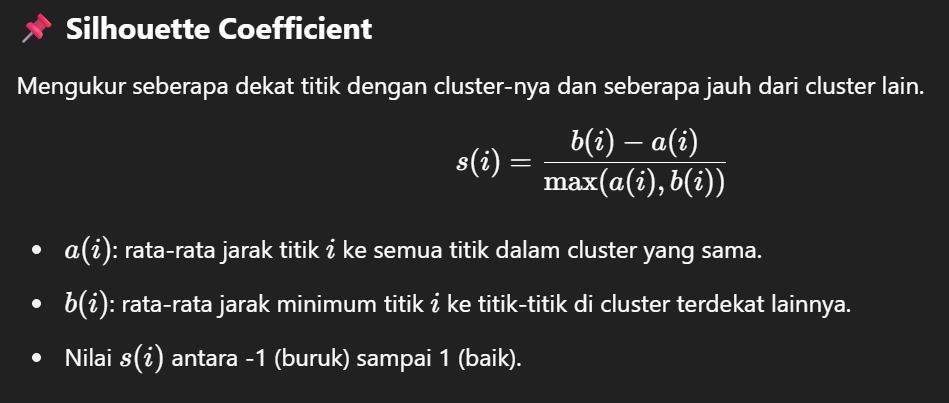

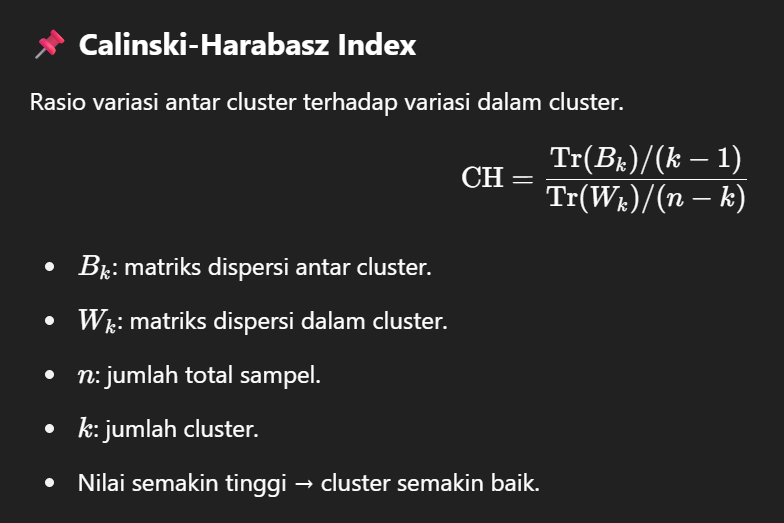

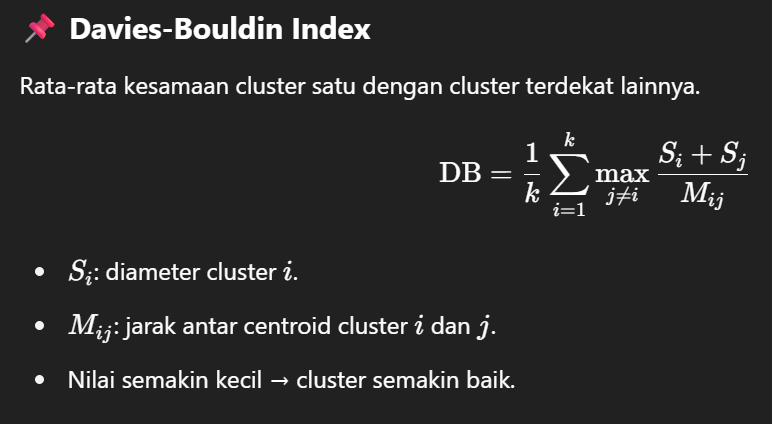

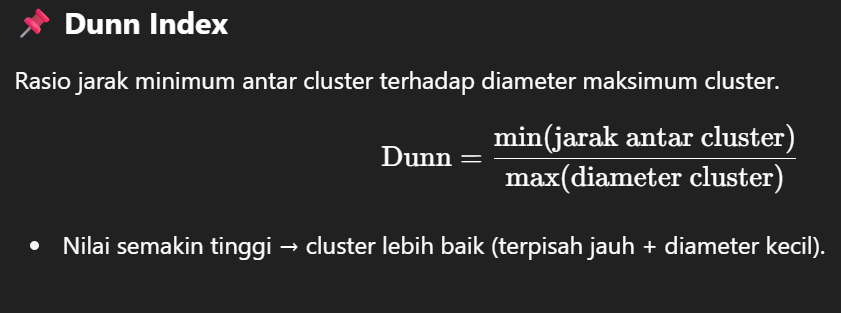